In [159]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [7]:
# building the dataset
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        
        #print(w)
        context = [0] * block_size
        
        for ch in w + '.':
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*(len(words)))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [10]:
C = torch.randn((27, 2))

In [12]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 2])

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100) 

In [14]:
# What we want to do is C @ W1 + b1 to get the hidden state but it is not possible due to dimensions mismatch.
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [15]:
h.shape

torch.Size([182625, 100])

In [16]:
W2 = torch.randn(100, 27)
b2 = torch.randn(27)

In [17]:
logits = h @ W2 + b2

In [18]:
counts = logits.exp()

In [19]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([182625, 27])

In [22]:
loss = -prob[torch.arange(Xtr.shape[0]), Ytr].log().mean()
loss

tensor(19.5413)

In [71]:
# --- now cleaner with generator for reproducability ---

In [150]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [151]:
sum(p.nelement() for p in parameters)

11897

In [152]:
for p in parameters:
    p.requires_grad = True

In [153]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [154]:
lri, lossi, stepi = [], [], []

In [155]:

for i in range(50000):

    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (100,))
    
    # foward pass
    emb = C[Xtr[ix]] # (32, 2, 3)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.2 if i<45000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    
#print(loss.item())

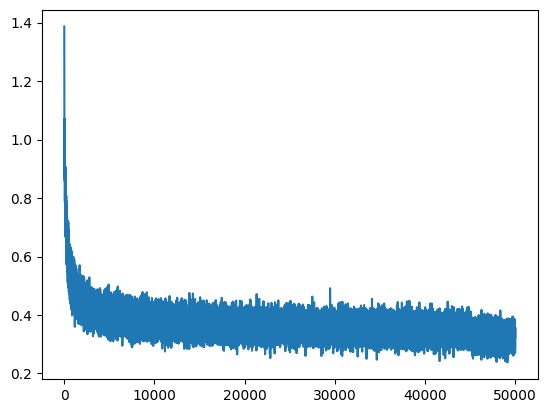

In [156]:
plt.plot(stepi, lossi)

In [157]:
emb = C[Xtr] # (32, 2, 3)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss
#plt.plot(lri, lossi)

tensor(2.1249, grad_fn=<NllLossBackward0>)

In [158]:
emb = C[Xdev] # (32, 2, 3)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1653, grad_fn=<NllLossBackward0>)

In [169]:
# Sampling

g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):

    out = []
    context = [0] * 3 # 3 is block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        out.append(ix)
        if ix==0:
            break
        context = context[1:] + [ix]

    print(''.join(itos[i] for i in out))
        

mora.
kayanniee.
mad.
rylle.
emmaniekd.
leg.
adelyn.
eliigh.
parelle.
eliean.
nar.
kayzirson.
ami.
shrusrishimiel.
kindretlynn.
novana.
ububacder.
yaqui.
els.
kay.
